# Modeling for Income Prediction Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import optuna
from optuna.samplers import TPESampler

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import TargetEncoder

from xgboost import plot_importance

import warnings
warnings.filterwarnings(action='ignore')

In [59]:
# 데이터 경로
path = "data/preprocessed.csv"
submission_path = "data/sample_submission.csv"
df = pd.read_csv(path)
submission_df = pd.read_csv(submission_path)

In [3]:
# 전체 컬럼 개수 : 22
len(df.columns)

22

## 데이터 분리

In [4]:
# concat 했던 train, test 데이터셋 분리
train = df.loc[:19999]
test = df.loc[20000:]
train.shape, test.shape

((20000, 22), (10000, 22))

In [5]:
# target 컬럼 "income"
target = "income"
# 나머지 컬럼 features에 선언
features = df.drop(columns=target).columns

# validation 데이터셋 생성
train, val = train_test_split(train, train_size=0.8, random_state=42)

In [6]:
# train 데이터 나눠준다
X_train = train[features]
y_train = train[target]

# validation 데이터 나눠준다
X_val = val[features]
y_val = val[target]

# test 데이터 나눠준다
X_test = test[features]
y_test = test[target]

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((16000, 21), (16000,), (4000, 21), (4000,), (10000, 21), (10000,))

In [7]:
# train 데이터 copy
X_train_no_enc = train[features].copy()

# validation 데이터 copy
X_val_no_enc = val[features].copy()

# test 데이터 copy
X_test_no_enc = test[features].copy()

### Target Encoding
- 머신 러닝 모델의 출력이 숫자 (회귀)일 때만 범주형 feature에 사용

- 각 범주에 대한 평균 목표값 계산 → 인코딩 하기 위해 범주형 값이 갖는 범주에 해당하는 백분율 대체
- 각 카테고리의 값을 학습 데이터의 target 값의 평균값으로 설정한다
- 데이터 관측치가 많아야 한다
- 과적합의 원인이 될 수 있다
- references
    - https://conanmoon.medium.com/%EB%8D%B0%EC%9D%B4%ED%84%B0%EA%B3%BC%ED%95%99-%EC%9C%A0%EB%A7%9D%EC%A3%BC%EC%9D%98-%EB%A7%A4%EC%9D%BC-%EA%B8%80%EC%93%B0%EA%B8%B0-%EC%9D%BC%EA%B3%B1%EB%B2%88%EC%A7%B8-%EC%9D%BC%EC%9A%94%EC%9D%BC-7a40e7de39d4
    - https://velog.io/@seungwoong12/encoding

In [8]:
# Scikit-learn TargetEncoder 사용
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.TargetEncoder.html
# Scikit-learn 버전 높아야 사용 가능 (업데이트 필요)

# 범주형 변수 목록 cat_features에 선언
cat_features = df.select_dtypes(exclude=np.number).columns.tolist()

# smooth="auto", cv=5로 TargetEncoder 객체 생성
te = TargetEncoder(target_type="continuous", smooth="auto", cv=5, random_state=42)

for cat_feature in cat_features:
    # Train 데이터로 fit_transform 해준다
    X_train[[cat_feature]] = te.fit_transform(X_train[[cat_feature]], y_train)
    X_val[[cat_feature]] = te.transform(X_val[[cat_feature]])
    X_test[[cat_feature]] = te.transform(X_test[[cat_feature]])

## Baseline 모델 생성

In [9]:
# 선형회귀 모델로 Baseline 모델 생성
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [10]:
# Baseline 모델 절편, 결정 계수 확인

print("Intercept: ", lr.intercept_)
print("Coefficients:")
list(zip(X_train, lr.coef_))

Intercept:  2409.119993074658
Coefficients:


[('id', -6.410594572731651),
 ('age', 0.3161763475061252),
 ('gender', 0.5535796295064188),
 ('education_status', 0.06662330147602455),
 ('employment_status', 0.07430989121062688),
 ('working_week (yearly)', 2.772530320259371),
 ('industry_status', 0.36805093364132113),
 ('occupation_status', 0.4204578486586156),
 ('race', -0.400319715535773),
 ('hispanic_origin', 0.48437547133799935),
 ('martial_status', 0.3023930409962961),
 ('household_summary', -0.06884137538859447),
 ('citizenship', 0.44442301095998915),
 ('birth_country', 0.7116493675709665),
 ('birth_country (father)', 0.16737509789169647),
 ('birth_country (mother)', -0.5659489797352615),
 ('tax_status', -0.07112811372203952),
 ('gains', -0.00420447275950997),
 ('losses', -0.006835896945167743),
 ('dividends', -0.0016878218575338),
 ('income_status', 0.40073981140266846)]

In [11]:
def baseline_model(model_name, model):
    baseline_results = []

    print(f"\n====== Baseline Model : {model_name} ======")
    
    # 모델 생성 및 훈련
    # model.fit(X_train, y_train)

    # Baseline 모델로 train, validation, test 데이터셋 예측
    y_train_pred_lr = model.predict(X_train)
    y_val_pred_lr = model.predict(X_val)

    # Baseline 모델의 MAE, MSE, RMSE, RMSLE, R2 score 확인
    base_meanAbErr = metrics.mean_absolute_error(y_val, y_val_pred_lr)
    base_meanSqErr = metrics.mean_squared_error(y_val, y_val_pred_lr)
    base_rootMeanSqErr = metrics.mean_squared_error(y_val, y_val_pred_lr, squared=False)


    # 결과를 리스트에 저장
    baseline_results.append({"Model" : model_name,
                             "MAE" : '{:.2f}'.format(base_meanAbErr),
                             "MSE" : '{:.2f}'.format(base_meanSqErr),
                             "RMSE" : '{:.2f}'.format(base_rootMeanSqErr),
                             "R2 Score" : '{:.2f}'.format(model.score(X_val, y_val))})
    
    # 결과 리스트를 DataFrame으로 변환
    baseline_df = pd.DataFrame(baseline_results)
    
    return baseline_df

In [12]:
baseline_model("Linear Regression", lr)


====== Baseline Model : Linear Regression ======


,Model,MAE,MSE,RMSE,R2 Score
0,Linear Regression,361.89,368271.79,606.85,0.25


## 머신러닝 모델링

### 하이퍼 파라미터 튜닝 전 모델 생성

In [13]:
model_list = ["lr_model", "dt_model", "rf_model", "cat_model", "lgbm_model", "xgb_model"]

lr_model = LinearRegression()
dt_model = DecisionTreeRegressor(random_state=42)
rf_model = RandomForestRegressor(random_state=42)
cat_model = CatBoostRegressor(random_state=42)
lgbm_model = LGBMRegressor(random_state=42)
xgb_model = XGBRegressor(random_state=42)

models = [
    ("Linear Regression", LinearRegression()),
    ("Decision Tree", DecisionTreeRegressor(random_state=42)),
    ("Random Forest", RandomForestRegressor(random_state=42)),
    ("CatBoost", CatBoostRegressor(random_state=42)),
    ("LightGBM", LGBMRegressor(random_state=42)),
    ("XGBoost", XGBRegressor(random_state=42))
]

In [14]:
def model_list(models, when="Before"):
    models_results = []

    for model_name, model in models:

        # 모델 생성 및 훈련
        # 트리 기반 모델들은 각 변수의 information gain을 기반으로 판단하기 때문에 굳이 스케일링 해줄 필요가 없다

        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        # 모델의 MAE, MSE, RMSE, RMSLE, R2 score 확인
        meanAbErr = metrics.mean_absolute_error(y_val, y_val_pred)
        meanSqErr = metrics.mean_squared_error(y_val, y_val_pred)
        rootMeanSqErr = metrics.mean_squared_error(y_val, y_val_pred, squared=False)


        # 결과를 리스트에 저장
        models_results.append({"Model" : model_name,
                                "MAE" : '{:.2f}'.format(meanAbErr),
                                "MSE" : '{:.2f}'.format(meanSqErr),
                                "RMSE" : '{:.2f}'.format(rootMeanSqErr),
                                "R2 Score" : '{:.2f}'.format(model.score(X_val, y_val))})
    
    # 결과 리스트를 DataFrame으로 변환
    models_df = pd.DataFrame(models_results)

    print(f"\n====== Models {when} Hyper Parameter Tuning ======")
    
    return models_df.sort_values(by=["RMSE", "R2 Score"], ascending=[True, False]).reset_index(drop=True)

In [15]:
model_list(models)

Learning rate set to 0.06345
0:	learn: 691.7610114	total: 133ms	remaining: 2m 13s
1:	learn: 682.7760026	total: 137ms	remaining: 1m 8s
2:	learn: 674.4849523	total: 140ms	remaining: 46.6s
3:	learn: 666.9157200	total: 143ms	remaining: 35.7s
4:	learn: 660.3493063	total: 147ms	remaining: 29.2s
5:	learn: 654.7682373	total: 150ms	remaining: 24.8s
6:	learn: 649.3445053	total: 153ms	remaining: 21.6s
7:	learn: 644.8031224	total: 155ms	remaining: 19.3s
8:	learn: 640.8849469	total: 158ms	remaining: 17.4s
9:	learn: 637.2148844	total: 162ms	remaining: 16s
10:	learn: 633.7133885	total: 165ms	remaining: 14.8s
11:	learn: 630.5293904	total: 168ms	remaining: 13.8s
12:	learn: 627.5647816	total: 170ms	remaining: 12.9s
13:	learn: 625.0568966	total: 173ms	remaining: 12.2s
14:	learn: 622.8094857	total: 176ms	remaining: 11.6s
15:	learn: 620.6796467	total: 179ms	remaining: 11s
16:	learn: 618.7258065	total: 182ms	remaining: 10.5s
17:	learn: 617.0197839	total: 185ms	remaining: 10.1s
18:	learn: 615.3221675	total: 

,Model,MAE,MSE,RMSE,R2 Score
0,LightGBM,336.50,356834.96,597.36,0.28
1,CatBoost,345.06,361842.10,601.53,0.27
2,Linear Regression,361.89,368271.79,606.85,0.25
3,Random Forest,345.23,371413.50,609.44,0.25
4,XGBoost,363.83,394022.70,627.71,0.20
5,Decision Tree,477.10,750749.06,866.46,-0.52


In [16]:
# 범주형 변수를 따로 Target Encoding 거치지 않은 데이터셋으로 학습한 CatBoost 확인
def model_list2(models, when="Before"):
    models_results = []

    for model_name, model in models:

        if model_name in ["CatBoost", "CatBoost_tuned"]:

            cat_features = X_train_no_enc.select_dtypes(exclude=np.number).columns.tolist()

            # 모델 생성 및 훈련
            model.fit(X_train_no_enc, y_train, cat_features=cat_features)

            # Robust Scaling 거치지 않은 train 데이터를 바탕으로 예측
            y_train_pred_cat = model.predict(X_train_no_enc)
            y_val_pred_cat = model.predict(X_val_no_enc)

            # 모델의 MAE, MSE, RMSE, RMSLE, R2 score 확인
            meanAbErr_cat = metrics.mean_absolute_error(y_val, y_val_pred_cat)
            meanSqErr_cat = metrics.mean_squared_error(y_val, y_val_pred_cat)
            rootMeanSqErr_cat = metrics.mean_squared_error(y_val, y_val_pred_cat, squared=False)

            # 결과를 리스트에 저장
            models_results.append({"Model" : model_name,
                                    "MAE" : '{:.2f}'.format(meanAbErr_cat),
                                    "MSE" : '{:.2f}'.format(meanSqErr_cat),
                                    "RMSE" : '{:.2f}'.format(rootMeanSqErr_cat),
                                    "R2 Score" : '{:.2f}'.format(model.score(X_val_no_enc, y_val))})
        
        else:
            
            # 모델 생성 및 훈련
            model.fit(X_train, y_train)

            y_train_pred = model.predict(X_train)
            y_val_pred = model.predict(X_val)

            # 모델의 MAE, MSE, RMSE, RMSLE, R2 score 확인
            meanAbErr = metrics.mean_absolute_error(y_val, y_val_pred)
            meanSqErr = metrics.mean_squared_error(y_val, y_val_pred)
            rootMeanSqErr = metrics.mean_squared_error(y_val, y_val_pred, squared=False)

            # 결과를 리스트에 저장
            models_results.append({"Model" : model_name,
                                    "MAE" : '{:.2f}'.format(meanAbErr),
                                    "MSE" : '{:.2f}'.format(meanSqErr),
                                    "RMSE" : '{:.2f}'.format(rootMeanSqErr),
                                    "R2 Score" : '{:.2f}'.format(model.score(X_val, y_val))})
    
    # 결과 리스트를 DataFrame으로 변환
    models_df = pd.DataFrame(models_results)

    print(f"\n====== Models {when} Hyper Parameter Tuning ======")
    
    return models_df.sort_values(by=["RMSE", "R2 Score"], ascending=[True, False]).reset_index(drop=True)

In [17]:
model_list2(models)

Learning rate set to 0.06345
0:	learn: 691.7622082	total: 57.6ms	remaining: 57.5s
1:	learn: 683.7692094	total: 123ms	remaining: 1m 1s
2:	learn: 675.9826120	total: 182ms	remaining: 1m
3:	learn: 668.9584278	total: 245ms	remaining: 1m
4:	learn: 662.8225594	total: 306ms	remaining: 1m
5:	learn: 657.3172312	total: 371ms	remaining: 1m 1s
6:	learn: 651.8863356	total: 433ms	remaining: 1m 1s
7:	learn: 647.5893365	total: 499ms	remaining: 1m 1s
8:	learn: 643.7359465	total: 566ms	remaining: 1m 2s
9:	learn: 640.2074560	total: 630ms	remaining: 1m 2s
10:	learn: 636.9176219	total: 690ms	remaining: 1m 2s
11:	learn: 634.5261287	total: 722ms	remaining: 59.5s
12:	learn: 631.9481607	total: 784ms	remaining: 59.5s
13:	learn: 629.4770639	total: 847ms	remaining: 59.6s
14:	learn: 627.2528706	total: 908ms	remaining: 59.6s
15:	learn: 625.3889100	total: 977ms	remaining: 1m
16:	learn: 623.5327667	total: 1.04s	remaining: 60s
17:	learn: 622.3441875	total: 1.08s	remaining: 58.9s
18:	learn: 621.3421509	total: 1.12s	rema

,Model,MAE,MSE,RMSE,R2 Score
0,CatBoost,337.94,355020.27,595.84,0.28
1,LightGBM,336.50,356834.96,597.36,0.28
2,Linear Regression,361.89,368271.79,606.85,0.25
3,Random Forest,345.23,371413.50,609.44,0.25
4,XGBoost,363.83,394022.70,627.71,0.20
5,Decision Tree,477.10,750749.06,866.46,-0.52


#### `CatBoost` 성능 비교
- 별도로 `Target Encoding` 거치지 않은 데이터셋으로 진행(`model_list2` 함수)한 `CatBoost`가 더 낮은 `RMSE` 기록

    - **601.53 vs 595.84** (CatBoost는 Target Encoding 실행하지 않은 데이터셋으로 진행)

### 하이퍼 파라미터 튜닝
- `RMSE`가 낮은 `CatBoost`, `LightGBM` 을 갖고 하이퍼 파라미터 튜닝
    - Baseline 모델인 `Linear Regression`의 `RMSE`보다 낮다 (606.85)
- `Random Forest`, `XGBoost`은 Baseline보다 `RMSE` 높지만 하이퍼파라이터 튜닝 시도

- `optuna` 활용
    - References : https://forecastegy.com/posts/xgboost-hyperparameter-tuning-with-optuna/


In [18]:
# optuna sampling seed 고정
sampler = TPESampler(seed=42)

#### CatBoost

In [19]:
def objective_cat(trial):
    params = {
        # "iterations": 1000,
        "iterations" : trial.suggest_int('n_estimators', 500, 4000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }
    cat_features = X_train_no_enc.select_dtypes(exclude=np.number).columns.tolist()

    model = CatBoostRegressor(**params, silent=True, random_state=42)
    model.fit(X_train_no_enc, y_train, cat_features=cat_features)
    predictions = model.predict(X_val_no_enc)
    rmse = metrics.mean_squared_error(y_val, predictions, squared=False)

    return rmse

In [20]:
study_cat = optuna.create_study(direction='minimize', sampler=sampler)
study_cat.optimize(objective_cat, n_trials=30)

[I 2024-04-06 03:01:56,914] A new study created in memory with name: no-name-627964a8-8fab-466d-b7a0-b4d5cee33853
[I 2024-04-06 03:04:16,381] Trial 0 finished with value: 603.9794680099925 and parameters: {'n_estimators': 1811, 'learning_rate': 0.07969454818643935, 'depth': 8, 'subsample': 0.6187255599871848, 'colsample_bylevel': 0.19821770842031466, 'min_data_in_leaf': 16}. Best is trial 0 with value: 603.9794680099925.
[I 2024-04-06 03:04:38,317] Trial 1 finished with value: 596.0067539976799 and parameters: {'n_estimators': 703, 'learning_rate': 0.05399484409787434, 'depth': 7, 'subsample': 0.7226689489062432, 'colsample_bylevel': 0.06955526958101232, 'min_data_in_leaf': 97}. Best is trial 1 with value: 596.0067539976799.
[I 2024-04-06 03:05:43,542] Trial 2 finished with value: 603.4694408188799 and parameters: {'n_estimators': 3414, 'learning_rate': 0.0026587543983272706, 'depth': 2, 'subsample': 0.22423428436076215, 'colsample_bylevel': 0.3390301308115608, 'min_data_in_leaf': 53}.

In [21]:
print("Best hyperparameters:", study_cat.best_params, sep="\n")
print("-----------------------------------------------------------------------------------------------------------------")
print("Best RMSE:", study_cat.best_value, sep="\n")

Best hyperparameters:
{'n_estimators': 1220, 'learning_rate': 0.012707276506775486, 'depth': 9, 'subsample': 0.3784090579858532, 'colsample_bylevel': 0.49526995794345, 'min_data_in_leaf': 70}
-----------------------------------------------------------------------------------------------------------------
Best RMSE:
595.2103960133783


In [22]:
# 하이퍼파라미터별 중요도를 확인할 수 있는 그래프
optuna.visualization.plot_param_importances(study_cat)

In [23]:
# 하이퍼파라미터 최적화 과정을 확인
optuna.visualization.plot_optimization_history(study_cat)

In [24]:
cat_optuna = CatBoostRegressor(**study_cat.best_params)
model_list2([("CatBoost_tuned", cat_optuna)], "After")

0:	learn: 699.5639473	total: 384ms	remaining: 7m 47s
1:	learn: 697.6528324	total: 510ms	remaining: 5m 10s
2:	learn: 695.7356134	total: 643ms	remaining: 4m 20s
3:	learn: 694.0031887	total: 740ms	remaining: 3m 45s
4:	learn: 692.1489845	total: 866ms	remaining: 3m 30s
5:	learn: 690.2684988	total: 991ms	remaining: 3m 20s
6:	learn: 688.5217747	total: 1.11s	remaining: 3m 12s
7:	learn: 686.7808050	total: 1.26s	remaining: 3m 10s
8:	learn: 685.1030194	total: 1.37s	remaining: 3m 4s
9:	learn: 683.3034223	total: 1.47s	remaining: 2m 58s
10:	learn: 681.5850839	total: 1.58s	remaining: 2m 53s
11:	learn: 679.9762856	total: 1.69s	remaining: 2m 50s
12:	learn: 678.4759797	total: 1.8s	remaining: 2m 47s
13:	learn: 676.8555719	total: 1.91s	remaining: 2m 44s
14:	learn: 675.4769262	total: 1.98s	remaining: 2m 38s
15:	learn: 674.0038510	total: 2.08s	remaining: 2m 36s
16:	learn: 672.5691442	total: 2.19s	remaining: 2m 35s
17:	learn: 671.0628581	total: 2.3s	remaining: 2m 33s
18:	learn: 669.6434724	total: 2.44s	remai

,Model,MAE,MSE,RMSE,R2 Score
0,CatBoost_tuned,334.96,354874.99,595.71,0.28


#### LightGBM

In [25]:
def objective_lgbm(trial):
    params = {
        "objective": "regression",
        "metric": "rmse",
        "n_estimators": trial.suggest_int('n_estimators', 500, 4000),
        "verbosity": -1,
        "bagging_freq": 1,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 2**10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }

    model = LGBMRegressor(**params, random_state=42)
    model.fit(X_train, y_train)
    predictions = model.predict(X_val)
    rmse = metrics.mean_squared_error(y_val, predictions, squared=False)


    return rmse

In [26]:
study_lgbm = optuna.create_study(direction='minimize', sampler=sampler)
study_lgbm.optimize(objective_lgbm, n_trials=30)

[I 2024-04-06 04:26:46,996] A new study created in memory with name: no-name-486dac2a-1561-4586-9135-14a030b62e54
[I 2024-04-06 04:26:52,502] Trial 0 finished with value: 596.5577285648221 and parameters: {'n_estimators': 1860, 'learning_rate': 0.003488976654890368, 'num_leaves': 849, 'subsample': 0.3889156603589098, 'colsample_bytree': 0.3168877842030117, 'min_data_in_leaf': 55}. Best is trial 0 with value: 596.5577285648221.
[I 2024-04-06 04:26:54,831] Trial 1 finished with value: 615.223640776728 and parameters: {'n_estimators': 993, 'learning_rate': 0.040215545266902894, 'num_leaves': 78, 'subsample': 0.9875425897704915, 'colsample_bytree': 0.7836325308318246, 'min_data_in_leaf': 20}. Best is trial 0 with value: 596.5577285648221.
[I 2024-04-06 04:27:02,866] Trial 2 finished with value: 628.0193995609515 and parameters: {'n_estimators': 519, 'learning_rate': 0.04274869455295218, 'num_leaves': 725, 'subsample': 0.742556809638938, 'colsample_bytree': 0.7827068293516485, 'min_data_in_

In [27]:
print("Best hyperparameters:", study_lgbm.best_params, sep="\n")
print("-----------------------------------------------------------------------------------------------------------------")
print("Best RMSE:", study_lgbm.best_value, sep="\n")

Best hyperparameters:
{'n_estimators': 2663, 'learning_rate': 0.0010606861438692452, 'num_leaves': 494, 'subsample': 0.5084261877845065, 'colsample_bytree': 0.681014559800181, 'min_data_in_leaf': 29}
-----------------------------------------------------------------------------------------------------------------
Best RMSE:
594.5609342136734


In [28]:
# 하이퍼파라미터별 중요도를 확인할 수 있는 그래프
optuna.visualization.plot_param_importances(study_lgbm)

In [29]:
# 하이퍼파라미터 최적화 과정을 확인
optuna.visualization.plot_optimization_history(study_lgbm)

In [30]:
lgbm_optuna = LGBMRegressor(**study_lgbm.best_params)
model_list2([("LightGBM_tuned", lgbm_optuna)], "After")

[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000962 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 979
[LightGBM] [Info] Number of data points in the train set: 16000, number of used features: 21
[LightGBM] [Info] Start training from score 556.153500
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

,Model,MAE,MSE,RMSE,R2 Score
0,LightGBM_tuned,342.82,354978.50,595.80,0.28


#### Random Forest

In [31]:
def objective_rf(trial):
    params = {
        # "iterations": 1000,
        "n_estimators" : trial.suggest_int('n_estimators', 500, 4000),
        # "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "max_samples": trial.suggest_float("max_samples", 0.05, 1.0),
        "max_features": trial.suggest_float("max_features", 0.05, 1.0),
        "min_weight_fraction_leaf": trial.suggest_int("min_weight_fraction_leaf", 0.05, 0.5),
    }

    model = RandomForestRegressor(**params, random_state=42)
    model.fit(X_train, y_train)
    predictions = model.predict(X_val)
    rmse = metrics.mean_squared_error(y_val, predictions, squared=False)

    return rmse

In [32]:
study_rf = optuna.create_study(direction='minimize', sampler=sampler)
study_rf.optimize(objective_rf, n_trials=30)

[I 2024-04-06 04:33:00,746] A new study created in memory with name: no-name-6b65bf67-1895-462d-8280-5bae1acdcf55
[I 2024-04-06 04:33:12,671] Trial 0 finished with value: 599.2644123282855 and parameters: {'n_estimators': 3326, 'max_depth': 9, 'max_samples': 0.35210330122327066, 'max_features': 0.15454932830129292, 'min_weight_fraction_leaf': 0}. Best is trial 0 with value: 599.2644123282855.
[I 2024-04-06 04:33:28,873] Trial 1 finished with value: 603.4166341791715 and parameters: {'n_estimators': 1298, 'max_depth': 5, 'max_samples': 0.8271140276263684, 'max_features': 0.8676940540935263, 'min_weight_fraction_leaf': 0}. Best is trial 0 with value: 599.2644123282855.
[I 2024-04-06 04:33:30,967] Trial 2 finished with value: 601.0314990288753 and parameters: {'n_estimators': 524, 'max_depth': 6, 'max_samples': 0.44654045299134, 'max_features': 0.26100241994719375, 'min_weight_fraction_leaf': 0}. Best is trial 0 with value: 599.2644123282855.
[I 2024-04-06 04:33:35,936] Trial 3 finished w

In [33]:
print("Best hyperparameters:", study_rf.best_params, sep="\n")
print("-----------------------------------------------------------------------------------------------------------------")
print("Best RMSE:", study_rf.best_value, sep="\n")

Best hyperparameters:
{'n_estimators': 1127, 'max_depth': 10, 'max_samples': 0.1323615144846687, 'max_features': 0.999664381952236, 'min_weight_fraction_leaf': 0}
-----------------------------------------------------------------------------------------------------------------
Best RMSE:
596.5012510852836


In [34]:
# 하이퍼파라미터별 중요도를 확인할 수 있는 그래프
optuna.visualization.plot_param_importances(study_rf)

In [35]:
# 하이퍼파라미터 최적화 과정을 확인
optuna.visualization.plot_optimization_history(study_rf)

In [36]:
rf_optuna = RandomForestRegressor(**study_rf.best_params)
model_list2([("RandomForest_tuned", rf_optuna)], "After")


====== Models After Hyper Parameter Tuning ======


,Model,MAE,MSE,RMSE,R2 Score
0,RandomForest_tuned,335.63,355778.96,596.47,0.28


#### XGBoost

In [37]:
def objective_xgb(trial):
    params = {
        "objective": "reg:squarederror",
        "n_estimators" : trial.suggest_int('n_estimators', 500, 4000),
        "verbosity": 0,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
    }

    model = XGBRegressor(**params, random_state=42)
    model.fit(X_train, y_train, verbose=False)
    predictions = model.predict(X_val)
    rmse = metrics.mean_squared_error(y_val, predictions, squared=False)

    return rmse

In [38]:
study_xgb = optuna.create_study(direction='minimize', sampler=sampler)
study_xgb.optimize(objective_xgb, n_trials=30)

[I 2024-04-06 04:40:30,817] A new study created in memory with name: no-name-ca72d9f9-b5e8-4d53-8762-ed4dbe5a9157


[I 2024-04-06 04:40:36,809] Trial 0 finished with value: 606.7393308659541 and parameters: {'n_estimators': 1787, 'learning_rate': 0.018391267498289014, 'max_depth': 7, 'subsample': 0.5589859498710206, 'colsample_bytree': 0.1357752815516879, 'min_child_weight': 17}. Best is trial 0 with value: 606.7393308659541.
[I 2024-04-06 04:40:39,142] Trial 1 finished with value: 607.279398040807 and parameters: {'n_estimators': 1623, 'learning_rate': 0.0023606794572813066, 'max_depth': 1, 'subsample': 0.6113482960288298, 'colsample_bytree': 0.6936861437501683, 'min_child_weight': 1}. Best is trial 0 with value: 606.7393308659541.
[I 2024-04-06 04:40:49,053] Trial 2 finished with value: 595.6548742317736 and parameters: {'n_estimators': 2292, 'learning_rate': 0.002837863814617626, 'max_depth': 7, 'subsample': 0.21564810755474184, 'colsample_bytree': 0.7063908511973427, 'min_child_weight': 8}. Best is trial 2 with value: 595.6548742317736.
[I 2024-04-06 04:40:58,740] Trial 3 finished with value: 59

In [39]:
print("Best hyperparameters:", study_xgb.best_params, sep="\n")
print("-----------------------------------------------------------------------------------------------------------------")
print("Best RMSE:", study_xgb.best_value, sep="\n")

Best hyperparameters:
{'n_estimators': 2993, 'learning_rate': 0.0029819350171149347, 'max_depth': 4, 'subsample': 0.759166834862123, 'colsample_bytree': 0.667151254094854, 'min_child_weight': 17}
-----------------------------------------------------------------------------------------------------------------
Best RMSE:
594.8370490655644


In [40]:
# 하이퍼파라미터별 중요도를 확인할 수 있는 그래프
optuna.visualization.plot_param_importances(study_xgb)

In [41]:
# 하이퍼파라미터 최적화 과정을 확인
optuna.visualization.plot_optimization_history(study_xgb)

In [42]:
xgb_optuna = XGBRegressor(**study_xgb.best_params)
model_list2([("XGBoost_tuned", xgb_optuna)], "After")


====== Models After Hyper Parameter Tuning ======


,Model,MAE,MSE,RMSE,R2 Score
0,XGBoost_tuned,336.91,353517.07,594.57,0.28


#### 튜닝한 모델들 비교

In [43]:
models_tuned = models = [
    ("CatBoost_tuned", cat_optuna),
    ("LightGBM_tuned", lgbm_optuna),
    ("RandomForest_tuned", rf_optuna),
    ("XGBoost_tuned", xgb_optuna)
]

In [44]:
model_list2(models_tuned, "After")

0:	learn: 699.5639473	total: 125ms	remaining: 2m 31s
1:	learn: 697.6528324	total: 256ms	remaining: 2m 36s
2:	learn: 695.7356134	total: 390ms	remaining: 2m 38s
3:	learn: 694.0031887	total: 443ms	remaining: 2m 14s
4:	learn: 692.1489845	total: 556ms	remaining: 2m 15s


5:	learn: 690.2684988	total: 688ms	remaining: 2m 19s
6:	learn: 688.5217747	total: 814ms	remaining: 2m 20s
7:	learn: 686.7808050	total: 995ms	remaining: 2m 30s
8:	learn: 685.1030194	total: 1.13s	remaining: 2m 32s
9:	learn: 683.3034223	total: 1.24s	remaining: 2m 29s
10:	learn: 681.5850839	total: 1.35s	remaining: 2m 28s
11:	learn: 679.9762856	total: 1.45s	remaining: 2m 26s
12:	learn: 678.4759797	total: 1.56s	remaining: 2m 24s
13:	learn: 676.8555719	total: 1.67s	remaining: 2m 24s
14:	learn: 675.4769262	total: 1.74s	remaining: 2m 19s
15:	learn: 674.0038510	total: 1.84s	remaining: 2m 18s
16:	learn: 672.5691442	total: 1.96s	remaining: 2m 18s
17:	learn: 671.0628581	total: 2.06s	remaining: 2m 17s
18:	learn: 669.6434724	total: 2.17s	remaining: 2m 16s
19:	learn: 668.3039964	total: 2.3s	remaining: 2m 18s
20:	learn: 666.9566105	total: 2.41s	remaining: 2m 17s
21:	learn: 665.6069943	total: 2.52s	remaining: 2m 17s
22:	learn: 664.2203923	total: 2.62s	remaining: 2m 16s
23:	learn: 663.0493445	total: 2.72

,Model,MAE,MSE,RMSE,R2 Score
0,XGBoost_tuned,336.91,353517.07,594.57,0.28
1,CatBoost_tuned,334.96,354874.99,595.71,0.28
2,LightGBM_tuned,342.82,354978.50,595.80,0.28
3,RandomForest_tuned,336.06,356193.54,596.82,0.28


#### 모델별 최적의 하이퍼파라미터

In [45]:
best_params_cat = {'n_estimators': 1220, 
                   'learning_rate': 0.012707276506775486, 
                   'depth': 9, 
                   'subsample': 0.3784090579858532, 
                   'colsample_bylevel': 0.49526995794345, 
                   'min_data_in_leaf': 70}

best_params_xgb = {'n_estimators': 2993, 
                   'learning_rate': 0.0029819350171149347, 
                   'max_depth': 4, 
                   'subsample': 0.759166834862123, 
                   'colsample_bytree': 0.667151254094854, 
                   'min_child_weight': 17}

best_params_lgbm = {'n_estimators': 2663, 
                    'learning_rate': 0.0010606861438692452, 
                    'num_leaves': 494, 
                    'subsample': 0.5084261877845065, 
                    'colsample_bytree': 0.681014559800181, 
                    'min_data_in_leaf': 29}

best_params_rf = {'n_estimators': 1127, 
                  'max_depth': 10, 
                  'max_samples': 0.1323615144846687, 
                  'max_features': 0.999664381952236, 
                  'min_weight_fraction_leaf': 0}


## 최적화 후 모델 재생성
- `XGBoost` : 가장 작은 RMSE 기록
    - RMSE : 594.57
    - R2 Score : 0.28
- `CatBoost` : 2번째로 작은 RMSE 기록
    - RMSE : 595.71
    - R2 Score : 0.28

### XGBoost

In [62]:
# optuna를 통해 생성한 하이퍼 파라미터로 조정하여, xgb 모델 생성
xgb_optuna.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.667151254094854, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.0029819350171149347,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=17, missing=nan, monotone_constraints=None,
             n_estimators=2993, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [63]:
rmse_xgb = metrics.mean_squared_error(y_val, xgb_optuna.predict(X_val),squared=False)
rmse_xgb

594.573017810245

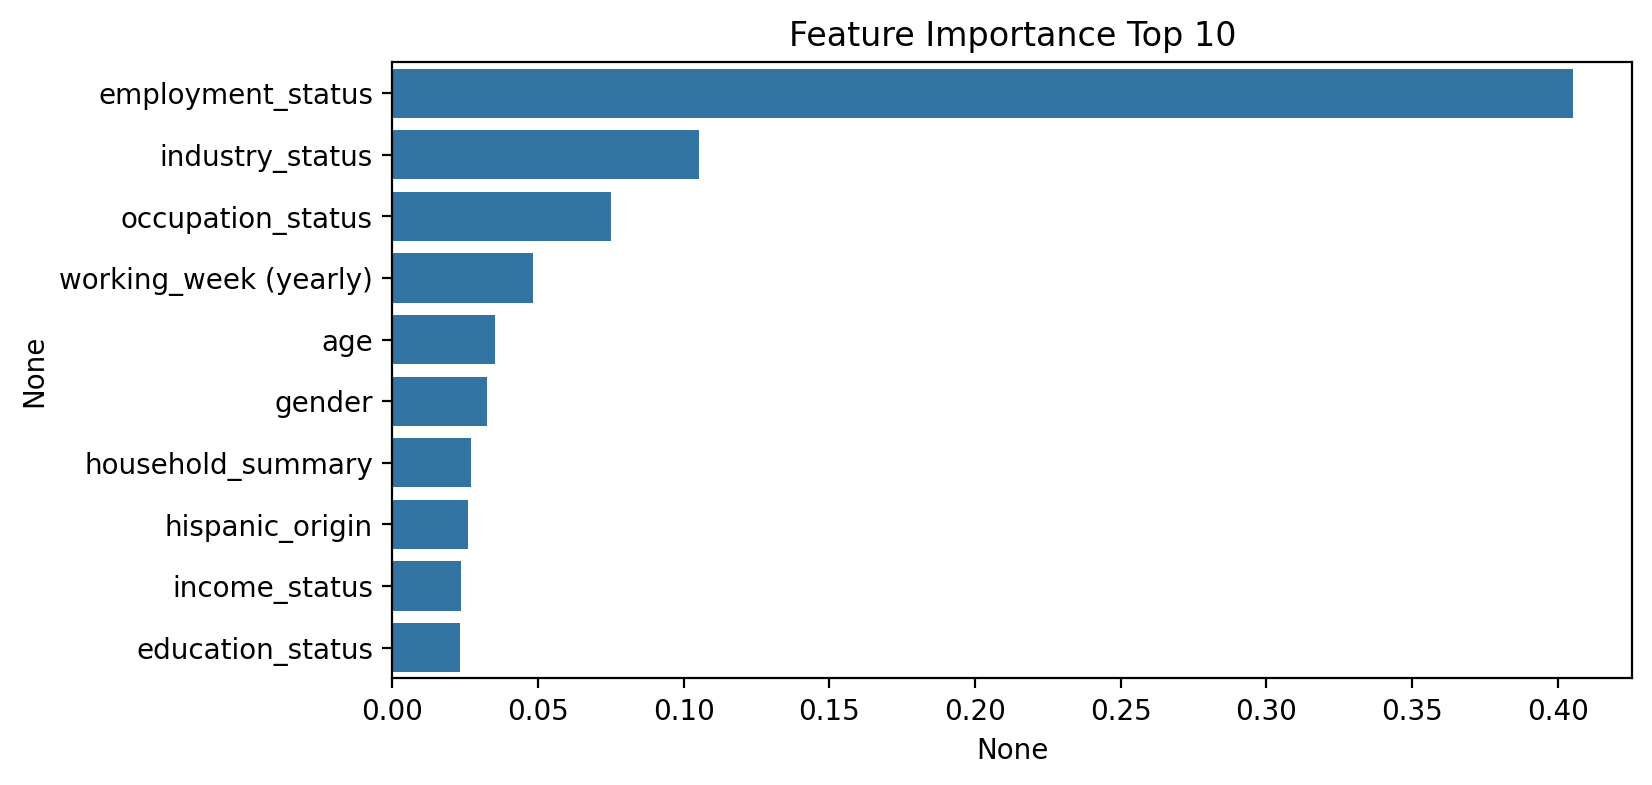

In [64]:
# feature importance 파악

# 배열형태로 반환
xgb_importance_values = xgb_optuna.feature_importances_

# 정렬과 시각화를 쉽게 하기 위해 series 전환
xgb_series = pd.Series(xgb_importance_values, index = X_train.columns)
xgb_top10 = xgb_series.sort_values(ascending=False)[:10]

# 시각화
plt.figure(figsize=(8,4))
plt.title('Feature Importance Top 10')
sns.barplot(x=xgb_top10, y=xgb_top10.index)
plt.show()


# 이 지표는 절대적이지 않다.
# 중요도는 낮게 평가되었지만 실제로 중요한 특성일 수도 있고,
# 그렇기 때문에 제거했을 경우 성능이 떨어질 수도 있다.
# -> 상위 n개의 특성들을 제외한 나머지 특성들을 모두 제거하는 방식은 바람직하지 못함

# feature importance를 고려하여 특성별로 A/B test 를 진행하며 feature selection 해야 한다
# https://hwi-doc.tistory.com/entry/Feature-selection-feature-importance-vs-permutation-importance

In [65]:
y_test_xgb = xgb_optuna.predict(X_test)
y_test_xgb

array([  4.49575  ,   1.5220261, 502.6014   , ..., 511.6868   ,
         6.097581 , 535.66125  ], dtype=float32)

In [66]:
submission_df["Income"] = y_test_xgb
submission_df.head()

,ID,Income
0,TEST_0000,4.495750
1,TEST_0001,1.522026
2,TEST_0002,502.601410
3,TEST_0003,520.905579
4,TEST_0004,-3.406885


In [67]:
# 전처리 완료한 파일 csv로 저장
submission_df.to_csv("data/submission_xgb.csv", index=False)

### CatBoost

In [46]:
# optuna를 통해 생성한 하이퍼 파라미터로 조정하여, CatBoost 모델 생성
cat_features = X_train_no_enc.select_dtypes(exclude=np.number).columns.tolist()
cat_optuna.fit(X_train_no_enc, y_train, cat_features=cat_features)

0:	learn: 699.5639473	total: 117ms	remaining: 2m 22s
1:	learn: 697.6528324	total: 235ms	remaining: 2m 23s
2:	learn: 695.7356134	total: 361ms	remaining: 2m 26s
3:	learn: 694.0031887	total: 411ms	remaining: 2m 4s
4:	learn: 692.1489845	total: 548ms	remaining: 2m 13s


5:	learn: 690.2684988	total: 676ms	remaining: 2m 16s
6:	learn: 688.5217747	total: 859ms	remaining: 2m 28s
7:	learn: 686.7808050	total: 1.01s	remaining: 2m 32s
8:	learn: 685.1030194	total: 1.12s	remaining: 2m 30s
9:	learn: 683.3034223	total: 1.23s	remaining: 2m 28s
10:	learn: 681.5850839	total: 1.34s	remaining: 2m 27s
11:	learn: 679.9762856	total: 1.48s	remaining: 2m 29s
12:	learn: 678.4759797	total: 1.61s	remaining: 2m 29s
13:	learn: 676.8555719	total: 1.73s	remaining: 2m 28s
14:	learn: 675.4769262	total: 1.79s	remaining: 2m 24s
15:	learn: 674.0038510	total: 1.89s	remaining: 2m 22s
16:	learn: 672.5691442	total: 2s	remaining: 2m 21s
17:	learn: 671.0628581	total: 2.11s	remaining: 2m 20s
18:	learn: 669.6434724	total: 2.21s	remaining: 2m 19s
19:	learn: 668.3039964	total: 2.32s	remaining: 2m 19s
20:	learn: 666.9566105	total: 2.42s	remaining: 2m 18s
21:	learn: 665.6069943	total: 2.54s	remaining: 2m 18s
22:	learn: 664.2203923	total: 2.65s	remaining: 2m 17s
23:	learn: 663.0493445	total: 2.77s	

In [54]:
rmse_cat = metrics.mean_squared_error(y_val, cat_optuna.predict(X_val_no_enc),squared=False)
rmse_cat

595.713851332828

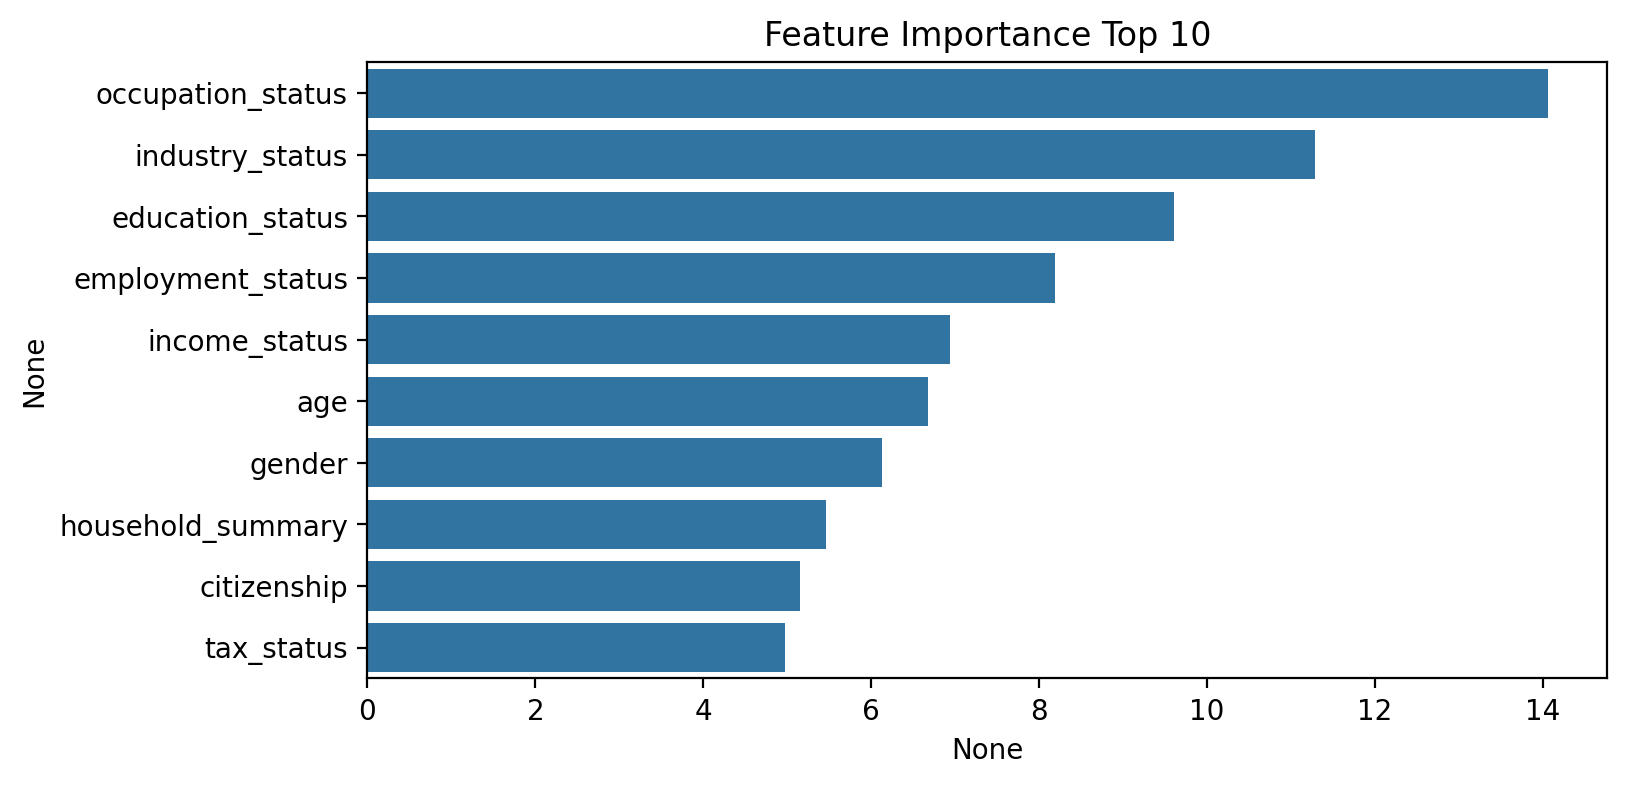

In [48]:
# feature importance 파악

# 배열형태로 반환
cat_importance_values = cat_optuna.feature_importances_

# 정렬과 시각화를 쉽게 하기 위해 series 전환
cat_series = pd.Series(cat_importance_values, index = X_train.columns)
cat_top10 = cat_series.sort_values(ascending=False)[:10]

# 시각화
plt.figure(figsize=(8,4))
plt.title('Feature Importance Top 10')
sns.barplot(x=cat_top10, y=cat_top10.index)
plt.show()


# 이 지표는 절대적이지 않다.
# 중요도는 낮게 평가되었지만 실제로 중요한 특성일 수도 있고,
# 그렇기 때문에 제거했을 경우 성능이 떨어질 수도 있다.
# -> 상위 n개의 특성들을 제외한 나머지 특성들을 모두 제거하는 방식은 바람직하지 못함

# feature importance를 고려하여 특성별로 A/B test 를 진행하며 feature selection 해야 한다
# https://hwi-doc.tistory.com/entry/Feature-selection-feature-importance-vs-permutation-importance

### 모델로 예측한 test 값

In [68]:
y_test_cat = cat_optuna.predict(X_test_no_enc)
y_test_cat

array([  9.60145457, -10.79933933, 506.2611891 , ..., 542.06369195,
         0.89458003, 522.36135223])

In [69]:
submission_df["Income"] = y_test_cat
submission_df.head()

,ID,Income
0,TEST_0000,9.601455
1,TEST_0001,-10.799339
2,TEST_0002,506.261189
3,TEST_0003,559.227863
4,TEST_0004,-2.327621


In [70]:
# 전처리 완료한 파일 csv로 저장
submission_df.to_csv("data/submission_cat.csv", index=False)